<a href="https://colab.research.google.com/github/saminehbagheri/AugmentedRBF-F10/blob/master/RBF_for_Ellipsoidal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Packages



In [0]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

#The Helper Functions for BBOB problems

**Tosz**: A deterministic noise function that can be added without adding any new local optima

In [0]:
def xHat(x):
  if x!=0:
    y=np.log(np.abs(x))
  else:
    y=0
  return y 
     


def Tosz(x):
    if x>0: 
      c1=10
      c2=7.9
    else: 
      c1=5.5
      c2=3.1
    xhat=xHat(x)
    ret=np.sign(x)*np.exp(xhat+0.049*(np.sin(c1*xhat)+np.sin(c2*xhat)))
    return ret

  
  
#Gram Schmidt

def gramschmidt(A):
    """
    Applies the Gram-Schmidt method to A
    and returns Q and R, so Q*R = A.
    """
    R = np.zeros((A.shape[1], A.shape[1]))
    Q = np.zeros(A.shape)
    for k in range(0, A.shape[1]):
        R[k, k] = np.sqrt(np.dot(A[:, k], A[:, k]))
        Q[:, k] = A[:, k]/R[k, k]
        for j in range(k+1, A.shape[1]):
            R[k, j] = np.dot(Q[:, k], A[:, j])
            A[:, j] = A[:, j] - R[k, j]*Q[:, k]
    return Q, R

#F10 Problem

In [0]:
def F10(x,dim,xopt,noise=True,LCN=6):
    x=x.reshape((dim,1))
    z=np.subtract(x,xopt)
    np.random.seed(435) 
    A=np.random.random((dim,dim))
    Q, R=gramschmidt(A)
    Z=z
    if noise:
      Z=np.apply_along_axis(Tosz, 1, Z)
    coef=np.arange(1,dim+1).reshape(dim,1)  
    coef=np.apply_along_axis(lambda x: np.power(10,(LCN*(x-1)/(dim-1))),1,coef)
    Z=np.multiply(coef,np.square(Z))
    Z=np.matmul(R,Z)
    y=np.sum(Z)
    return y
      
      
#x=np.array([0,0]).reshape(2,1)
#xopt=np.array([0,0]).reshape(2,1)
#F10(x,dim=2,xopt=xopt)

#Augmented RBF Interpolation

Augmented RBF is an RBF with a polynomial tail. In this implementation a second order polynomial tail is used

In [0]:
def RBFtrain(X,F):
  DIST=distance_matrix(X,X)
  ##using cubic rbf kernel
  K=np.power(DIST,3)
  P=np.append(np.ones(shape=(X.shape[0],1)),X,axis=1)
  P=np.append(P,np.power(X,2),axis=1)
  PT=P.transpose()
  ZEROS=np.zeros(shape = (P.shape[1],P.shape[1]))
  PHI=np.append(K,P,axis=1)
  PHI=np.append(PHI,np.append(PT,ZEROS,axis=1),axis=0)
  zeros=np.zeros(shape=(P.shape[1],1))
  F=np.append(F,zeros,axis=0)
  rbfcoef=np.matmul(np.linalg.pinv(PHI),F)
  CENTERS=X
  return rbfcoef, CENTERS
  
  



def RBFpredict(rbfcoef,CENTERS,X):  
    DIST=distance_matrix(X,CENTERS)
    DIST=np.power(DIST,3)
    PHI=np.append(DIST,np.ones(shape=(X.shape[0],1)),axis=1)
    PHI=np.append(PHI,X,axis=1)
    PHI=np.append(PHI,np.power(X,2),axis=1)
    predict=np.matmul(PHI,rbfcoef)
    return(predict)


#X=np.random.random((10,2))
#F=np.random.random((10,1))
#rbfcoef, CENTERS=RBFtrain(X,F)
#predict=RBFpredict(rbfcoef,CENTERS,X)
#print(predict)
#print(F)


#The SlicePlot Function

This function plots slices (its projection on each dimension) of the F10 (with and without noise) and its model at a given point $x$ 


In [0]:
def SlicePlot(x,LCN,noise,CENTERS,rbfcoef,xopt):
  samples=200
  dim=x.shape[0]
  x=np.repeat(x.transpose(),samples,axis=0)
  myseq=np.linspace(-5, 5, num=samples)
  myseq.reshape((samples,1))
  rows=np.ceil(dim/4).astype(int)
  fig, axs = plt.subplots(rows,4, facecolor='w', edgecolor='k',figsize=(16, 4*rows))
  fig.subplots_adjust(hspace = 5, wspace=1)
  axs = axs.ravel()
  fig.suptitle('noise:'+str(noise))
  for i in range(dim):
      x[:, i] =myseq
      realFunc=np.apply_along_axis(F10,axis=0,arr=x.transpose(),dim=dim,xopt=xopt,noise=noise,LCN=LCN)
      modelFunc=RBFpredict(rbfcoef,CENTERS,x)
      #fig = plt.figure()
      #ax = plt.axes()
      axs[i].plot(myseq, realFunc,linewidth=8)
      axs[i].plot(myseq, modelFunc,linewidth=4,linestyle='--')
      axs[i].set_title('d='+str(i+1))
      
  return  axs
    
    
    
    

#Training F10 with RBF (d=2)

In [8]:
dim=2
trainSize=2*dim+1
testSize=2
noise=True
LCN=10


Xtrain=np.random.random((trainSize,dim))*10-5
Xtest=np.random.random((testSize,dim))*10-5

xopt=np.zeros(shape=(dim,1))

Ftrain=np.apply_along_axis(F10,axis=0,arr=Xtrain.transpose(),dim=dim,xopt=xopt,noise=noise,LCN=LCN)
Ftrain=Ftrain.reshape((trainSize,1))
rbfcoef, CENTERS=RBFtrain(Xtrain,Ftrain)
predictTrain=RBFpredict(rbfcoef,CENTERS,Xtrain)
predictTest=RBFpredict(rbfcoef,CENTERS,Xtest)


Ftest=np.apply_along_axis(F10,axis=0,arr=Xtest.transpose(),dim=dim,xopt=xopt,noise=noise,LCN=LCN)
Ftest=Ftest.reshape((testSize,1))

#print(Xtrain)
#print(Xtest)
print(np.sqrt(np.average(np.square(np.subtract(predictTest,Ftest)))))
#print(np.subtract(predictTrain,Ftrain))

5508547495.628997


#Analysing Functions


1.   RMSE(): calculates the RMSE of the given model on testSize points 
2.   Analyse(): This function get the dimension and the LCN ($log_{10}(Condition ~Number)$) and it returns:


      * Plots comparing the modeling quality of F10 with noise and F10 without noise
      * RMSE of the models for F10 with and without the deterministic noise Tosz







RMSE for the F10 (d=4,LCN=10) with the deterministic noise (Tosz):113054861320.976
RMSE for the F10 (d=4,LCN=10) without the deterministic noise (Tosz):0.00464927849633921
noiseRMSE-RMSE=113054861320.97134
rmseRatio:noiseRMSE/RMSE=24316646423739.54


(0.00464927849633921, 113054861320.976)

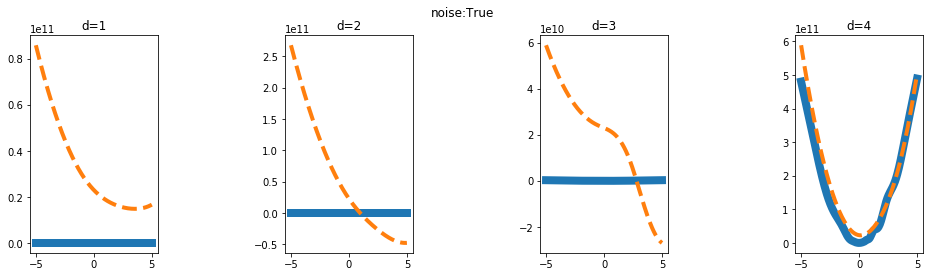

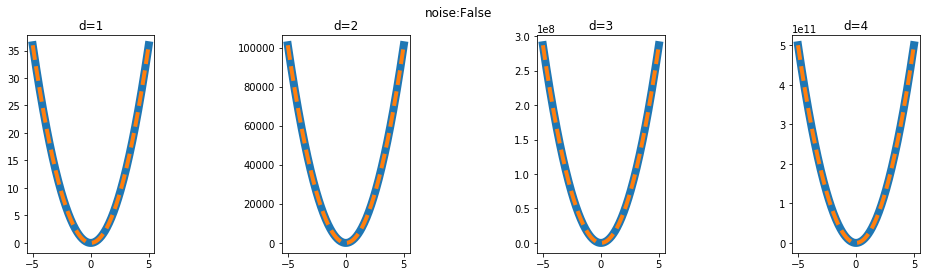

In [44]:
def RMSEcalc(rbfcoef,CENTERS,noise,LCN,dim,xopt,testSize,seed=678):
  np.random.seed(seed) 
  Xtest=np.random.random((testSize*dim,dim))*10-5
  predictTest=RBFpredict(rbfcoef,CENTERS,Xtest)
  Ftest=np.apply_along_axis(F10,axis=0,arr=Xtest.transpose(),dim=dim,xopt=xopt,noise=noise,LCN=LCN)
  Ftest=Ftest.reshape((testSize*dim,1))
  RMSE=np.sqrt(np.average(np.square(np.subtract(predictTest,Ftest))))
  return RMSE

def Analyse(dim, LCN, DOPLOT=True, Trace=False):
  trainSize=3*dim+1
  testSize=100

  Xtrain=np.random.random((trainSize,dim))*10-1
  xopt=np.zeros(shape=(dim,1))
  
  #with noise
  noise=True
  Ftrain=np.apply_along_axis(F10,axis=0,arr=Xtrain.transpose(),dim=dim,xopt=xopt,noise=noise,LCN=LCN)
  Ftrain=Ftrain.reshape((trainSize,1))
  rbfcoef, CENTERS=RBFtrain(Xtrain,Ftrain)
  predictTrain=RBFpredict(rbfcoef,CENTERS,Xtrain)
  noiseRMSE=RMSEcalc(rbfcoef,CENTERS,noise,LCN,dim,xopt,testSize)
  if DOPLOT:
     SlicePlot(xopt,LCN,noise,CENTERS,rbfcoef,xopt)
  
  
  #without noise
  noise=False
  Ftrain=np.apply_along_axis(F10,axis=0,arr=Xtrain.transpose(),dim=dim,xopt=xopt,noise=noise,LCN=LCN)
  Ftrain=Ftrain.reshape((trainSize,1))
  rbfcoef, CENTERS=RBFtrain(Xtrain,Ftrain)
  predictTrain=RBFpredict(rbfcoef,CENTERS,Xtrain)
  RMSE=RMSEcalc(rbfcoef,CENTERS,noise,LCN,dim,xopt,testSize)
  if DOPLOT:
     SlicePlot(xopt,LCN,noise,CENTERS,rbfcoef,xopt)
  #ratio=np.log(noiseRMSE)-np.log(RMSE)


  if Trace:
   print("RMSE for the F10 (d="+str(dim)+",LCN="+str(LCN)+ ") with the deterministic noise (Tosz):"+str(noiseRMSE))
   print("RMSE for the F10 (d="+str(dim)+",LCN="+str(LCN)+ ") without the deterministic noise (Tosz):"+str(RMSE))
   print("noiseRMSE-RMSE="+str(noiseRMSE-RMSE))
   print("rmseRatio:noiseRMSE/RMSE="+str(noiseRMSE/RMSE))
  return RMSE, noiseRMSE


Analyse(4, 10,Trace=True)

Text(0, 0.5, 'log(RMSE)')

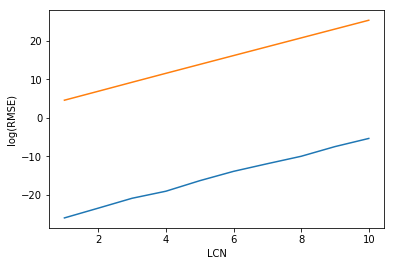

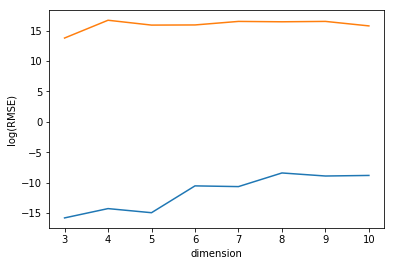

In [45]:
RMSEArray=[]
noiseRMSEArray=[]
LCNS=range(1,11)
for LCN in LCNS:
   RMSE, noiseRMSE=Analyse(4, LCN, DOPLOT=False)
   RMSEArray.append(np.log(RMSE))
   noiseRMSEArray.append(np.log(noiseRMSE))


fig = plt.figure()
ax = plt.axes()
ax.plot(LCNS, RMSEArray);   
ax.plot(LCNS, noiseRMSEArray);   
ax.set_xlabel('LCN')
ax.set_ylabel('log(RMSE)')


RMSEArray=[]
noiseRMSEArray=[]
DIMS=range(3,11)
for dim in DIMS:
   RMSE, noiseRMSE=Analyse(dim, 6, DOPLOT=False)
   RMSEArray.append(np.log(RMSE))
   noiseRMSEArray.append(np.log(noiseRMSE))


fig = plt.figure()
ax = plt.axes()
ax.plot(DIMS, RMSEArray);   
ax.plot(DIMS, noiseRMSEArray);
ax.set_xlabel('dimension')
ax.set_ylabel('log(RMSE)')


In [0]:
DIMS=np.arange(3,11).astype(int)
LCNS=np.arange(1,11).astype(int)
VAnalyse = np.vectorize(Analyse)
RMSEMat=np.empty((0,DIMS.shape[0]))
noiseRMSEMat=np.empty((0,DIMS.shape[0]))

#for LCN in LCNS:
#  print(LCN)
#  RMSE, noiseRMSE = np.apply_along_axis(Analyse, 0, arr=DIMS, LCN=LCN, DOPLOT=False)
for LCN in LCNS:
  RMSE, noiseRMSE=VAnalyse(DIMS,LCN=LCN, DOPLOT=False)
  RMSEMat=np.append(RMSEMat,RMSE.reshape(1,DIMS.shape[0]),axis=0)
  noiseRMSEMat=np.append(noiseRMSEMat,noiseRMSE.reshape(1,DIMS.shape[0]),axis=0)




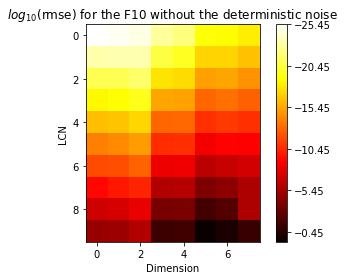

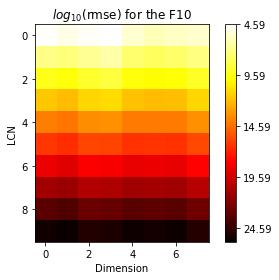

In [69]:

plt.imshow(np.log(RMSEMat),cmap='hot_r')
cbar=plt.colorbar()
cbar.ax.invert_yaxis()
cbar.update_ticks()
cbar.set_ticks(np.arange(np.min(np.log(RMSEMat)),np.max(np.log(RMSEMat)),5))
plt.title('$log_{10}$(rmse) for the F10 without the deterministic noise', fontsize=12)
plt.xlabel('Dimension')
plt.ylabel('LCN')
plt.show()

plt.imshow(np.log(noiseRMSEMat),cmap='hot_r')
cbar=plt.colorbar()
cbar.ax.invert_yaxis()
cbar.update_ticks()
cbar.set_ticks(np.arange(np.min(np.log(noiseRMSEMat)),np.max(np.log(noiseRMSEMat)),5))
plt.title('$log_{10}$(rmse) for the F10', fontsize=12)
plt.xlabel('Dimension')
plt.ylabel('LCN')
plt.show()